# Import Libraries

In [ ]:
import tensorflow as tf
import urllib.request
import zipfile
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.preprocessing import image
from keras.optimizers import RMSprop
import numpy as np
from keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt

In [ ]:
# function for printing horse or human based on result
def horse_or_human(filename, result):
    if result > 0.5:
        print(f'{filename} is a human')
    else:
        print(f'{filename} is a horse')

# Custom Keras Callback

In [ ]:
class KerasCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

# Download and Prepare Datasets

In [ ]:
# training dataset url
training_url = "https://storage.googleapis.com/learning-datasets/horse-or-human.zip"
# training file name and directory
training_file_name = "horse-or-human.zip"
training_dir = 'horse-or-human/training/'
# download the training dataset
urllib.request.urlretrieve(training_url, training_file_name)

# extract to directory
zip_ref = zipfile.ZipFile(training_file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

# validation dataset url
validation_url = "https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip"
# validation file name and directory
validation_file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
# download the validation data set
urllib.request.urlretrieve(validation_url, validation_file_name)

# extract to directory
zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

# Create Data Generators for Training and Validation Datasets

In [ ]:
# all images will be rescaled by 1./255 and augment then images
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(250, 250),
    class_mode='binary'
)

# all images will be rescaled by 1./255
validation_datagen = ImageDataGenerator(
    rescale=1/255.
)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(250, 250),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# Download the Pre-trained Model and Weights

In [ ]:
# download the weights and pre-trained model
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)
pre_trained_model = InceptionV3(
    input_shape=(250, 250, 3),
    include_top=False,
    weights=None
)

# load the weights
pre_trained_model.load_weights(weights_file)
# set the layer as not trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

# get the last layer of the pre-trained model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

NameError: ignored

# Create / Compile Model

In [ ]:
# flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model.summary()

# Retrain the Model

In [ ]:
# create the callback
callback = KerasCallback()

history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=10,
  callbacks=[callback]
)

In [ ]:
print(history.history.keys())

training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
vavlidation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# print(f'training loss: {training_loss}')
# print(f'training accuracy: {training_accuracy}')
# print(f'validation loss: {vavlidation_loss}')
# print(f'validation accuracy: {validation_accuracy}')

# plot accuracy training vs. validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# plot loss training vs. validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Test Actual Images

## Download the Images

In [ ]:
actual_images_dl = 'https://drive.google.com/uc?export=download&id=1guy6SPfNId625-dDk43w5bxKeZX0luwt'
filename = "actual_samples.zip"
dir = 'actual_samples'

urllib.request.urlretrieve(actual_images_dl, filename)

# extract to directory
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(dir)
zip_ref.close()

## Function for Printing Horse or Human

1/1 [==============================] - 1s 1s/step
image1.jpg is a human


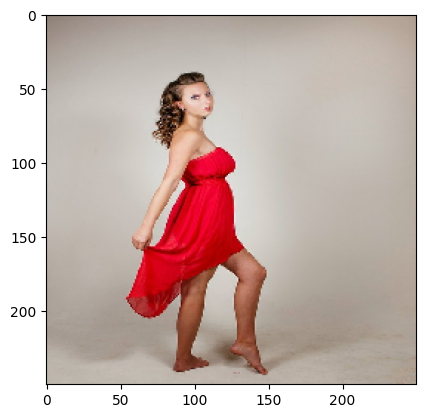

In [ ]:
# image1.jpg
image1 = image.load_img(dir + '/image1.jpg', target_size = (250, 250))
# show image
plt.imshow(image1)
# convert image to tensor
image1_np = image.img_to_array(image1) / 255.
image1_np = np.expand_dims(image1_np, axis=0) # extend to make 3D array
image1_tensor = np.vstack([image1_np])
# make inference
classes = model.predict(image1_tensor)
result = classes[0]
horse_or_human('image1.jpg', result)

1/1 [==============================] - 0s 185ms/step
image2.jpg is a horse


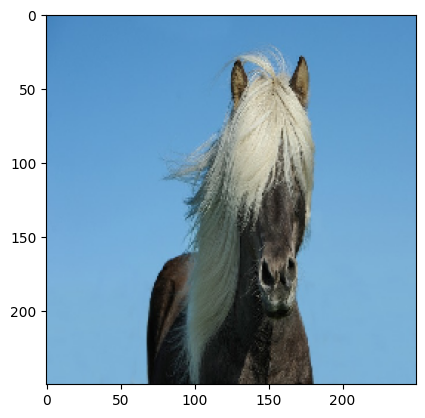

In [ ]:
# image2.jpg
image2 = image.load_img(dir + '/image2.jpg', target_size = (250, 250))
# show image
plt.imshow(image2)
# convert image to tensor
image2_np = image.img_to_array(image2) / 255.
image2_np = np.expand_dims(image2_np, axis=0) # extend to make 3D array
image2_tensor = np.vstack([image2_np])
# make inference
classes = model.predict(image2_tensor)
result = classes[0]
horse_or_human('image2.jpg', result)

1/1 [==============================] - 0s 157ms/step
image3.jpg is a human


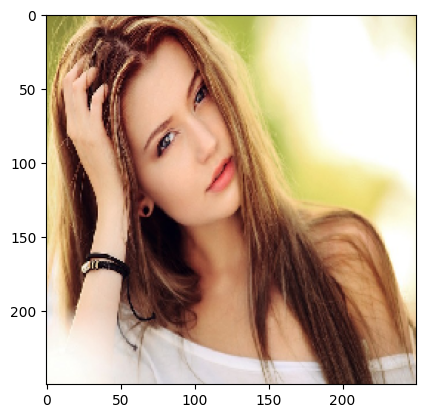

In [ ]:
# image3.jpg
image3 = image.load_img(dir + '/image3.jpg', target_size = (250, 250))
# show image
plt.imshow(image3)
# convert image to tensor
image3_np = image.img_to_array(image3) / 255.
image3_np = np.expand_dims(image3_np, axis=0) # extend to make 3D array
image3_tensor = np.vstack([image3_np])
# make inference
classes = model.predict(image3_tensor)
result = classes[0]
horse_or_human('image3.jpg', result)